In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

import phik
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import clip_grad_norm_
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

In [29]:
df = pd.read_csv('data.csv', encoding='ISO-8859-1')

In [30]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [32]:
# Standardize the column names: all lowercase, spaces replaced with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Display the standardized column names to confirm the changes
df.columns.tolist()

['row_id',
 'order_id',
 'order_date',
 'ship_date',
 'ship_mode',
 'customer_id',
 'customer_name',
 'segment',
 'country',
 'city',
 'state',
 'postal_code',
 'region',
 'product_id',
 'category',
 'sub-category',
 'product_name',
 'sales',
 'quantity',
 'discount',
 'profit']

In [33]:
# Convert 'order_date' and 'ship_date' to datetime format
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['ship_date'] = pd.to_datetime(df['ship_date'], errors='coerce')

In [34]:
# Check unique values in categorical columns for consistency
categorical_columns = ['ship_mode', 'segment', 'country', 'region', 'category', 'sub-category']
categorical_uniques = {column: df[column].unique() for column in categorical_columns}

In [35]:
# Statistical summary for numerical columns to identify potential outliers
numerical_summary = df.describe()

In [36]:
# Date Features Engineering
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month
df['order_day'] = df['order_date'].dt.day
df['order_day_of_week'] = df['order_date'].dt.dayofweek
df['is_weekend'] = df['order_day_of_week'].isin([5, 6]).astype(int)
df['shipping_duration'] = (df['ship_date'] - df['order_date']).dt.days

In [37]:
df.drop('row_id', axis=1, inplace=True)
df.drop('order_id', axis=1, inplace=True)
df.drop('order_date', axis=1, inplace=True)
df.drop('ship_date', axis=1, inplace=True)
df.drop('customer_id', axis=1, inplace=True)
df.drop('customer_name', axis=1, inplace=True)
df.drop('country', axis=1, inplace=True)
df.drop('postal_code', axis=1, inplace=True)
df.drop('product_id', axis=1, inplace=True)

In [38]:
# Calculate unit price as sales divided by quantity
df['unit_price'] = df['sales'] / df['quantity']

# To illustrate the approach, let's take a look at the distribution of unit prices within a specific sub-category
# We'll choose a sub-category with a diverse range of products. For demonstration, let's use "Binders"
binders_unit_prices = df[df['sub-category'] == 'Binders']['unit_price']

# Display basic statistics to understand the distribution of unit prices within "Binders"
binders_unit_prices.describe()

count    1523.000000
mean       36.672279
std       141.421271
min         0.336000
25%         2.742000
50%         5.380000
75%        15.010000
max      1889.990000
Name: unit_price, dtype: float64

In [39]:

def optimal_clusters(data, max_k=10):
    """
    Determine the optimal number of clusters using the Elbow Method and Silhouette Score.
    """
    scores = []
    silhouette_scores = []
    K_range = range(2, max_k + 1)
    cluster_centers = {}

    for K in K_range:
        kmeans = KMeans(n_clusters=K, random_state=42).fit(data)
        scores.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    # Silhouette Method: Find the number of clusters with the highest silhouette score
    best_silhouette_index = np.argmax(silhouette_scores)
    best_k = K_range[best_silhouette_index]
    best_kmeans = KMeans(n_clusters=best_k, random_state=42).fit(data)
    
    # Save the cluster centers for the best K
    cluster_centers['centers'] = best_kmeans.cluster_centers_
    cluster_centers['n_clusters'] = best_k

    return best_kmeans.labels_, cluster_centers

# Initialize a dictionary to store cluster centers for each sub-category
sub_category_cluster_centers = {}

# Assuming 'df' is your DataFrame
clustered_data = pd.DataFrame()
for sub_category in df['sub-category'].unique():
    sub_category_data = df[df['sub-category'] == sub_category].copy()
    prices = sub_category_data[['unit_price']]

    if len(prices) > 1:  # Ensure there's enough data for clustering
        labels, centers = optimal_clusters(prices)
        sub_category_data['price_cluster'] = labels
        sub_category_cluster_centers[sub_category] = centers
    else:
        sub_category_data['price_cluster'] = 0  # Assign to a single cluster if not enough data

    clustered_data = pd.concat([clustered_data, sub_category_data])

# 'clustered_data' now includes the 'price_cluster' column, and 'sub_category_cluster_centers' stores the cluster centers for each sub-category.


In [40]:
# Adjust cluster labels to be distinct across different sub-categories
clustered_data['distinct_cluster_label'] = clustered_data['sub-category'] + '_' + clustered_data['price_cluster'].astype(str)

In [41]:
clustered_data.distinct_cluster_label.nunique()

38

In [42]:
clustered_data.drop('product_name', axis=1, inplace=True)

In [43]:
# phik correlation
phik_matrix = clustered_data.phik_matrix()

interval columns not set, guessing: ['sales', 'quantity', 'discount', 'profit', 'order_year', 'order_month', 'order_day', 'order_day_of_week', 'is_weekend', 'shipping_duration', 'unit_price', 'price_cluster']


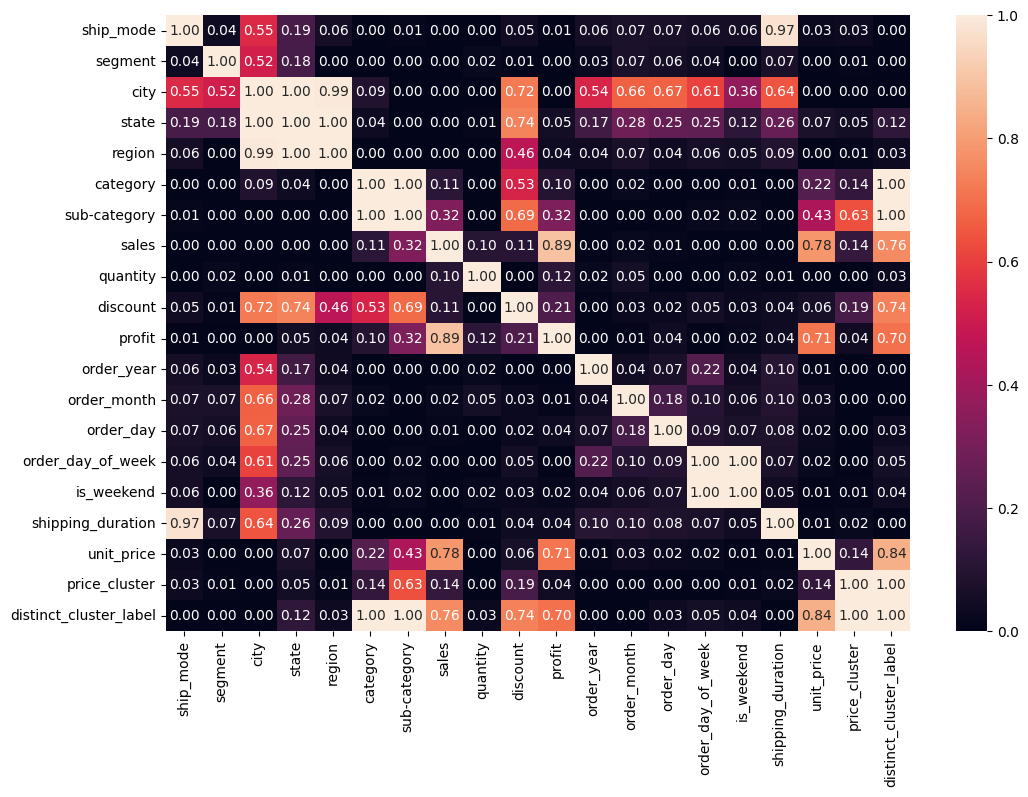

In [44]:
plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, fmt=".2f")
plt.show()

In [45]:
# Isolate the correlation with profit
correlation_with_profit_phik = phik_matrix['profit'].sort_values(ascending=False)
print(correlation_with_profit_phik)

profit                    1.000000
sales                     0.893351
unit_price                0.714247
distinct_cluster_label    0.699394
sub-category              0.319992
discount                  0.206762
quantity                  0.115840
category                  0.095263
state                     0.050452
price_cluster             0.044965
order_day                 0.038294
shipping_duration         0.037399
region                    0.035284
is_weekend                0.018712
order_month               0.008245
ship_mode                 0.007790
segment                   0.000000
order_year                0.000000
order_day_of_week         0.000000
city                      0.000000
Name: profit, dtype: float64


In [46]:
# Function to handle outliers within a DataFrame column
def handle_outliers(df):
    # Applying clipping for each column in the DataFrame
    df = df.copy()
    for column in df.columns:
        lower_bound = df[column].quantile(0.01)
        upper_bound = df[column].quantile(0.99)
        df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

# Selecting features and target variable
features = ['sales', 'unit_price', 'discount', 'quantity', 'distinct_cluster_label', 'sub-category', 'state', 'order_day']
target = 'profit'

X = clustered_data[features]
y = clustered_data[target]

# Splitting data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define numerical and categorical features
numerical_features = ['sales', 'unit_price', 'discount', 'quantity']
categorical_features = ['distinct_cluster_label', 'sub-category', 'state']

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('outliers', FunctionTransformer(func=handle_outliers, validate=False)),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ])

# Apply preprocessing pipeline to your data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

In [47]:
import torch

# Convert the preprocessed data into dense format and then PyTorch tensors
X_train_tensor = torch.tensor(X_train_preprocessed.toarray(), dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_preprocessed.toarray(), dtype=torch.float)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_preprocessed.toarray(), dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


In [48]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32  # You can adjust the batch size
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [49]:
class ComplexNet(nn.Module):
    def __init__(self, num_features):
        super(ComplexNet, self).__init__()
        self.layer1 = nn.Linear(num_features, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        
        self.layer2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        
        self.layer3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.5)
        
        self.layer4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(0.5)
        
        self.output = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.layer1(x))))
        x = self.dropout2(F.relu(self.bn2(self.layer2(x))))
        x = self.dropout3(F.relu(self.bn3(self.layer3(x))))
        x = self.dropout4(F.relu(self.bn4(self.layer4(x))))
        x = self.output(x)
        return x


# Initialize the model
model = ComplexNet(X_train_tensor.shape[1])

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ComplexNet(
  (layer1): Linear(in_features=58, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (layer4): Linear(in_features=64, out_features=32, bias=True)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=32, out_features=1, bias=True)
)

In [50]:
# Define the criterion for regression
criterion = nn.MSELoss()

# Assume optimizer is defined
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# Define the scheduler
scheduler_plateau = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Set the early stopping patience
early_stopping_patience = 100

# Set the model save path
model_save_path = '/path/to/save/model'  # Ensure this directory exists
model_filename = 'best_model.pth'
full_model_path = os.path.join(model_save_path, model_filename)

# Ensure the save directory exists
os.makedirs(model_save_path, exist_ok=True)

min_val_loss = np.inf
patience_counter = 0

In [51]:
train_losses = []
val_losses = []

num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Calculate average loss over the epoch
    train_loss = train_loss / len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item() * inputs.size(0)
    
    # Calculate average validation loss
    val_loss = val_loss / len(val_loader.dataset)
    
    # Record the average losses
    train_losses.append(train_loss / len(train_loader.dataset))
    val_losses.append(val_loss / len(val_loader.dataset))

    # Scheduler step for ReduceLROnPlateau
    scheduler_plateau.step(val_loss)
    
    # Early Stopping check
    if val_loss < min_val_loss:
        print(f'Validation loss decreased ({min_val_loss:.6f} --> {val_loss:.6f}). Saving model...')
        min_val_loss = val_loss
        
        # Save the model
        torch.save(model.state_dict(), full_model_path)
        patience_counter = 0  # Reset patience counter on improvement
    else:
        patience_counter += 1  # Increment patience counter if no improvement
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break
            
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


c:\Users\farha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\farha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\farha\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incor

Validation loss decreased (inf --> 25629.613589). Saving model...
Epoch 1, Train Loss: 66610.7377, Val Loss: 25629.6136
Validation loss decreased (25629.613589 --> 25620.305203). Saving model...
Epoch 2, Train Loss: 66596.3537, Val Loss: 25620.3052
Validation loss decreased (25620.305203 --> 25611.622808). Saving model...
Epoch 3, Train Loss: 66581.0066, Val Loss: 25611.6228
Validation loss decreased (25611.622808 --> 25602.675798). Saving model...
Epoch 4, Train Loss: 66564.3057, Val Loss: 25602.6758
Validation loss decreased (25602.675798 --> 25591.436263). Saving model...
Epoch 5, Train Loss: 66550.2117, Val Loss: 25591.4363
Validation loss decreased (25591.436263 --> 25581.572863). Saving model...
Epoch 6, Train Loss: 66536.0265, Val Loss: 25581.5729
Validation loss decreased (25581.572863 --> 25568.043221). Saving model...
Epoch 7, Train Loss: 66521.2775, Val Loss: 25568.0432
Validation loss decreased (25568.043221 --> 25555.959970). Saving model...
Epoch 8, Train Loss: 66505.8129

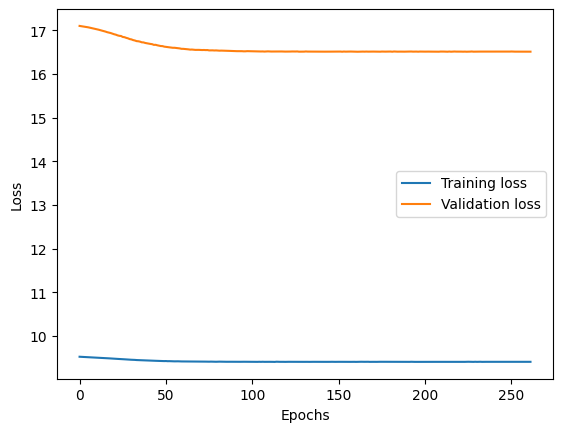

In [52]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


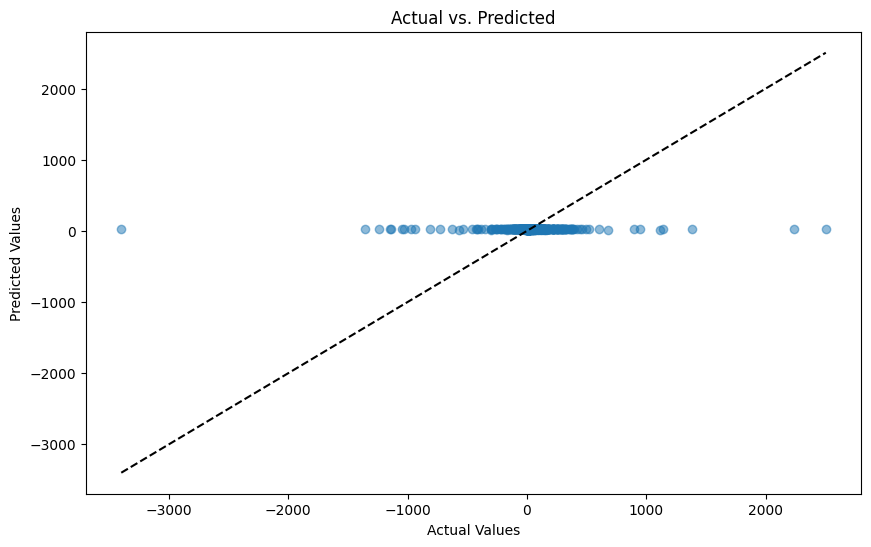

In [53]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.view(-1).tolist())
        actuals.extend(targets.tolist())

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted')
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--')  # Diagonal line
plt.show()


In [54]:
predictions

[22.97450065612793,
 21.507966995239258,
 19.18605613708496,
 20.95026397705078,
 19.82331657409668,
 21.864694595336914,
 20.992992401123047,
 19.557126998901367,
 19.698713302612305,
 19.797901153564453,
 20.14738655090332,
 23.34671974182129,
 19.419952392578125,
 20.875436782836914,
 21.075998306274414,
 20.535446166992188,
 19.53123664855957,
 21.1345272064209,
 20.294572830200195,
 19.155824661254883,
 19.45783805847168,
 20.03892707824707,
 21.337190628051758,
 18.689233779907227,
 19.463685989379883,
 22.7994441986084,
 20.636037826538086,
 20.911447525024414,
 19.754030227661133,
 20.651029586791992,
 21.505151748657227,
 22.141939163208008,
 21.094663619995117,
 21.18891143798828,
 23.048139572143555,
 19.687307357788086,
 19.48885154724121,
 20.47770881652832,
 19.690950393676758,
 21.05003547668457,
 19.646726608276367,
 20.41652488708496,
 21.141077041625977,
 23.087785720825195,
 22.014989852905273,
 22.303319931030273,
 22.936721801757812,
 19.32408332824707,
 19.8311977